 

Today we have aircon in our homes, offices, transportation and shopping malls.

This is because Singapore is located just 137 kilometers (85 miles) north of the equator. Most people would describe Singapore climate as hot and humid conditions all year round with no seasons of winter, spring, summer and winter.

The island does not have clear-cut seasons like summer, spring, autumn and winter. The weather is warm and humid all year round. ... Due to its geographical location and maritime exposure, Singapore's climate is characterized by uniform temperature and pressure, high humidity and abundant rainfall.

In [214]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [211]:
#meant = pd.read_csv("../datasets/surface-air-temperature-monthly-mean.csv")

def parser(x):
    return datetime.strptime(x,'%Y-%m')

meant = pd.read_csv("../datasets/surface-air-temperature-monthly-mean.csv",index_col=0, parse_dates=[0] ,date_parser=parser)

In [212]:
meant

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0
...,...
2020-03-01,28.6
2020-04-01,28.9
2020-05-01,28.9


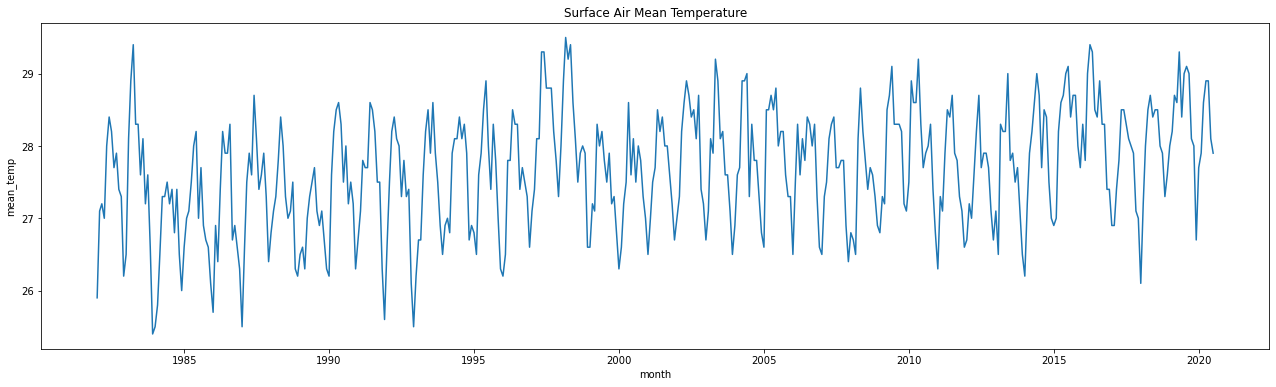

In [213]:
plt.figure(figsize=(22,6))
sns.lineplot(x=meant.index, y=meant['mean_temp'])
plt.title('Surface Air Mean Temperature')
plt.show()

<img src="../monthly_mean.png" />

The above plot shows temperatures are higher in the middle of the year and lower at the beginning and end of the year, which suggests seasonality in Singapore's conditions. But the differences are very small and the temperatures are on the high side.

Now I will show the temperature variations in a heatmap. Note that the hottest months are between March and Sep.

In [148]:
meant['monthly'] = meant.index.month
meant['yearly'] = meant.index.year
pivot_meant = pd.pivot_table(meant, values='mean_temp', index='monthly', columns='yearly', aggfunc='mean')
meant_seasonality = pivot_meant.mean(axis=1)

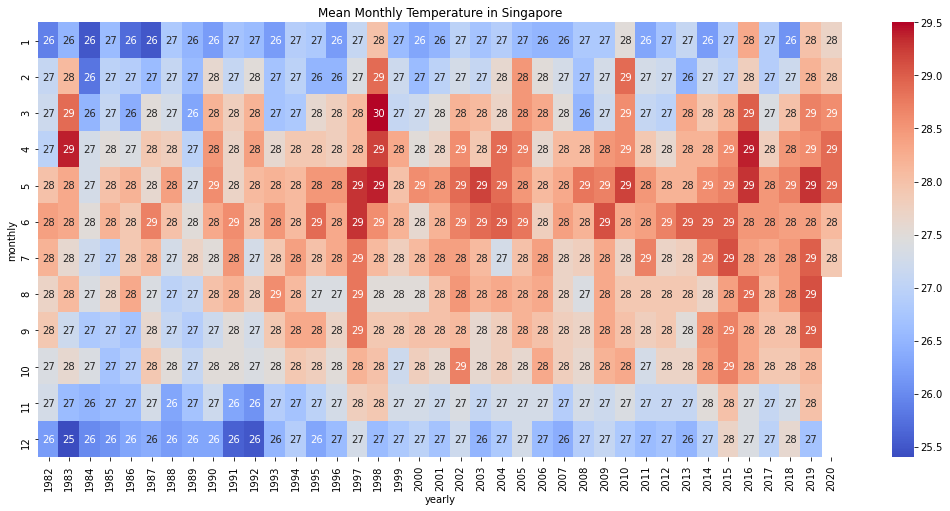

In [155]:
plt.figure(figsize=(18,8))
seasonality = meant.pivot("monthly", "yearly", "mean_temp")
sns.heatmap(seasonality, annot=True, cmap="coolwarm")
plt.title("Mean Monthly Temperature in Singapore")
plt.show()

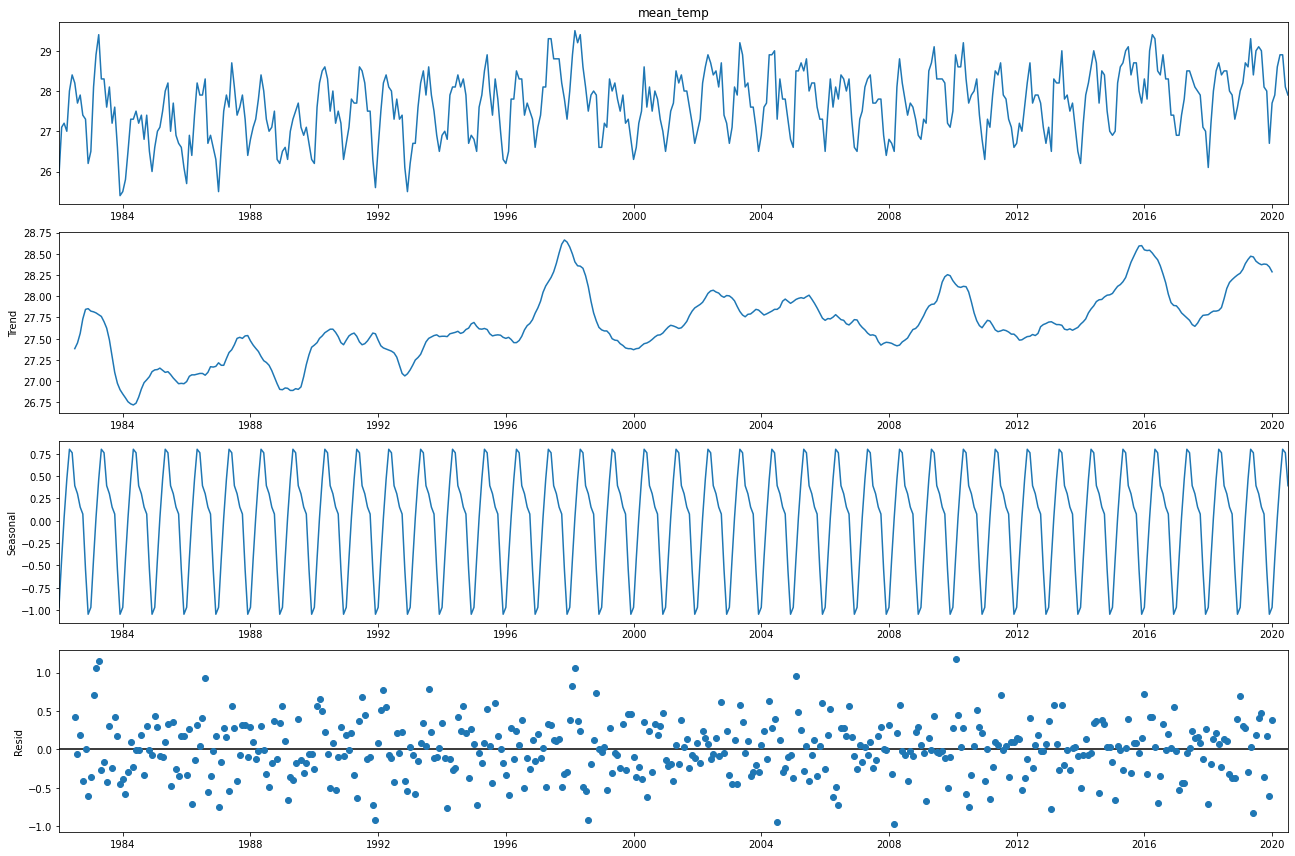

In [165]:
# Check for trend and seasonality
from pylab import rcParams
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(meant['mean_temp'], model='additive')
fig = decomposition.plot()
plt.show()

Trend shows temperature is moving up marginally over the years

Seaonality shows lower temperature near the end and beginning of the year, and higher in the middle of the year, implying time lag is 12

Before I use ARIMA model I need to remove any stationarity in the data

In [258]:
# Split data into train and test

train = meant['mean_temp'][:443]
test = meant['mean_temp'][443:]

## Stationarity check - Rolling mean, std dev

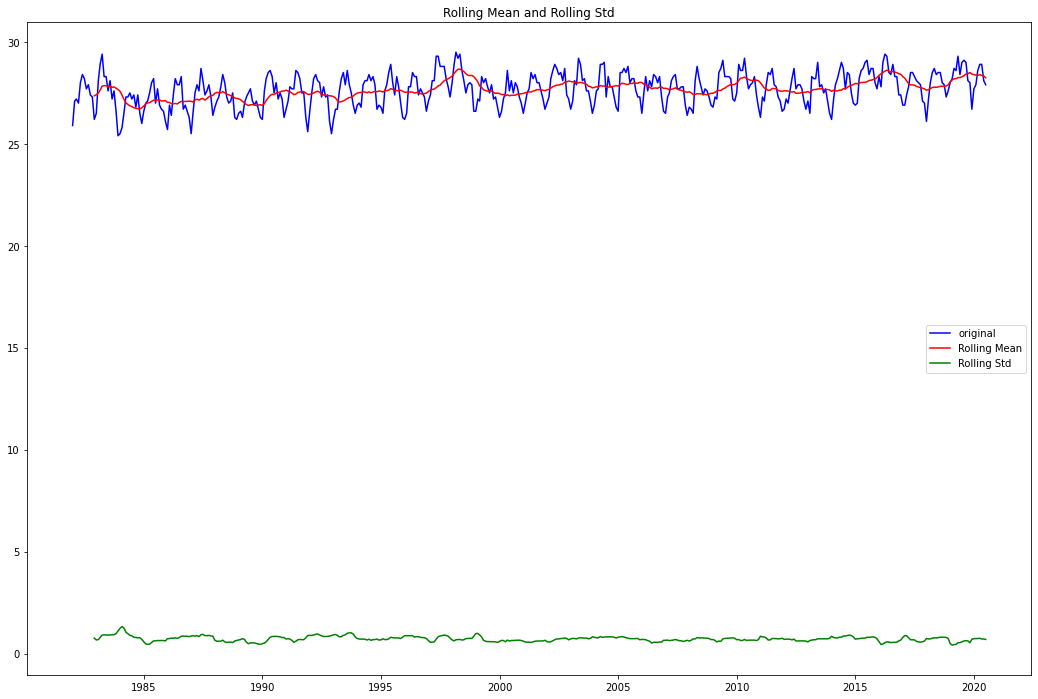

In [187]:
# Check for stationarity using rolling mean and standard deviation

rolmean = meant['mean_temp'].rolling(window=12).mean()
rolstd = meant['mean_temp'].rolling(window=12).std()

orig = plt.plot(meant['mean_temp'],color='blue',label='original')
mean = plt.plot(rolmean,color='red',label='Rolling Mean')
std = plt.plot(rolstd,color='green',label='Rolling Std')
plt.legend()
plt.title('Rolling Mean and Rolling Std')
plt.show(block=False)

The above plot shows rolling mean and standard deviation are relatively constant, implying data is stationary. Any trend or sesonality is negligible.

## Stationarity check - adfuller

In [192]:
# Check for stationarity using adfuller

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(meant['mean_temp'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Test Statistic                  -4.368361
p-value                          0.000338
#Lags Used                      18.000000
Number of Observations Used    444.000000
Critical Value (1%)             -3.445164
Critical Value (5%)             -2.868072
Critical Value (10%)            -2.570249
dtype: float64


In the adfuller test the p-value is smaller than 0.05, which means I can statistically reject the null hypothesis that the data is not stationary.

## Stationarity check - ACF, PACF

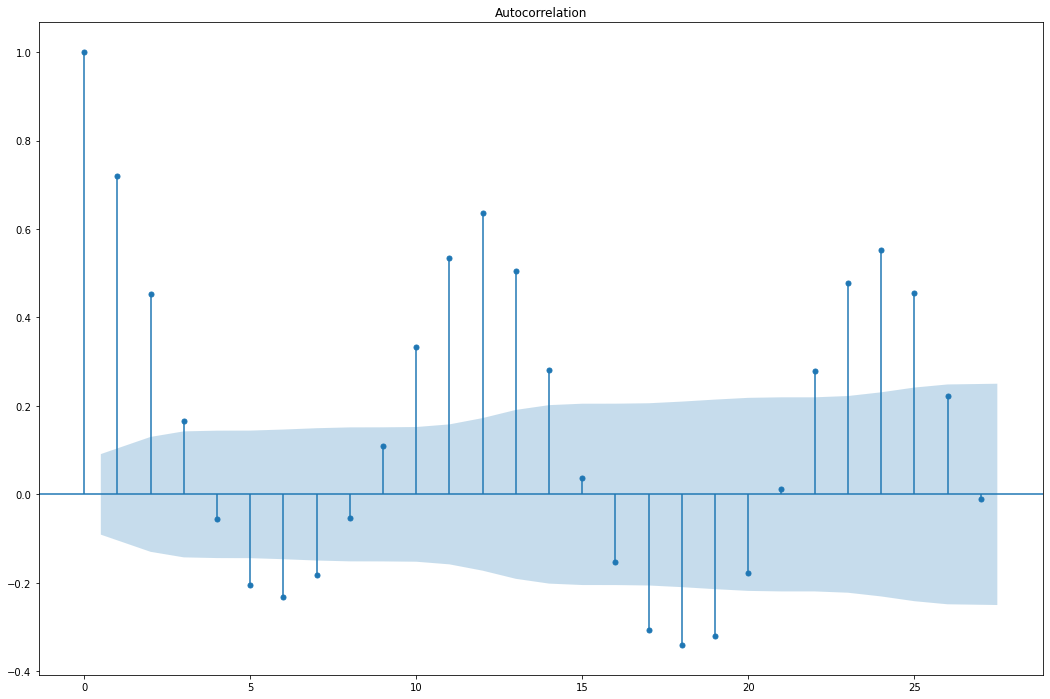

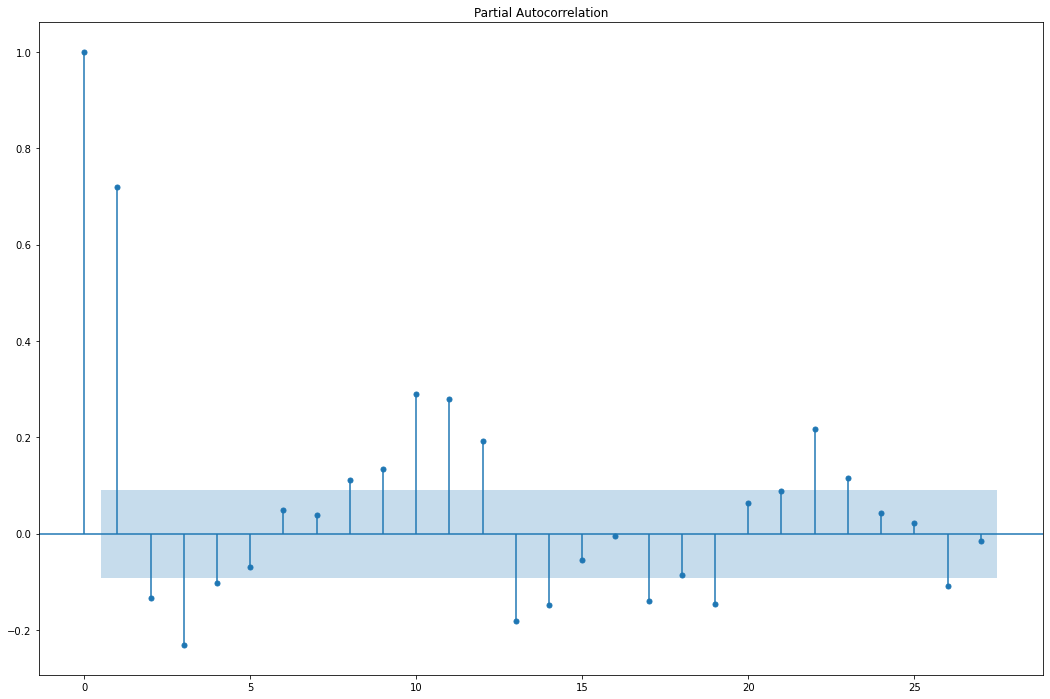

In [190]:
plot_acf(meant['mean_temp'])
plt.show()
plot_pacf(meant['mean_temp'])
plt.show()

PACF plot shows autocorrelation quickly drops to between -0.2 and +0.3, suggesting there is no stationarity 

## Stationarity check - nsdiffs and ndiffs

In [244]:
pm.arima.nsdiffs(train, m=12, test="ch", max_D=3)

0

In [245]:
pm.arima.nsdiffs(train, m=12, test="ocsb", max_D=3)

0

nsdiffs shows that we do not need to perform any seasonal differencing

In [246]:
from pmdarima.arima.utils import ndiffs, diff
ndiffs(train, alpha=0.05, test='kpss', max_d=5)

1

ndiffs asserts that we should only difference once. Let's look at how the time series looks after differencing once

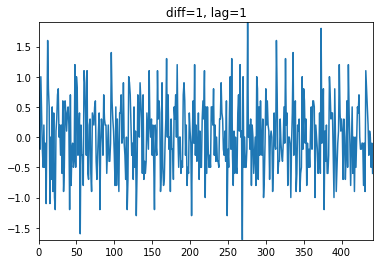

In [247]:
def plot_ts(x, title="Time series"):
    n_samples = x.shape[0]

    plt.plot(np.arange(n_samples), x)
    plt.axis([0, n_samples, x.min(), x.max()])
    plt.title(title)
    plt.show()
    
plot_ts(diff(train, differences=1, lag=1), title="diff=1, lag=1")

In [248]:
from pmdarima.arima import auto_arima

# We'll give it a broad range of parameters to search, though it might take a bit.
arima = auto_arima(train,  # this is our unlagged data
                   exogenous=None,  # if you have covariates, you can regress against them as well (optionally)
                   start_p=1, max_p=5,
                   start_q=1, max_q=5,
                   start_P=1, max_P=3,
                   start_Q=1, max_Q=3,
                   d=1, D=0,  # we have already estimated our d and D, so no need to compute it again
                   max_order=None,  # do not limit the order of parameters for this search
                   stepwise=True,  # faster
                   error_action='ignore',  # do not care if we find parameters that fail; skip them
                   trace=True, seasonal=True, m=3)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[3] intercept   : AIC=740.818, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=806.092, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=804.641, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=801.292, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=804.105, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[3] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,1,1)(1,0,0)[3] intercept   : AIC=806.630, Time=0.39 sec
 ARIMA(1,1,1)(2,0,1)[3] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,1)(1,0,2)[3] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=803.196, Time=0.41 sec
 ARIMA(1,1,1)(0,0,2)[3] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,1,1)(2,0,0)[3] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,1,1)(2,0,2)[3] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,1)(1,0,1)[3] intercept   : AIC=798.484, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[3] intercept   : AIC=798.568, Time=0.59 sec
 ARIMA

In [249]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  443
Model:             SARIMAX(2, 1, 2)x(3, 0, [], 3)   Log Likelihood                -314.830
Date:                            Mon, 24 Aug 2020   AIC                            645.660
Time:                                    03:13:52   BIC                            678.391
Sample:                                         0   HQIC                           658.570
                                            - 443                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9108      0.032    -28.266      0.000      -0.974      -0.848
ar.L2         -0.8521      0.034    -24.992      0.000      -0.919      -0.785
ma.L1          0.4725      0.056      8.511      0.000       0.364       0.581
ma.L2          0.3009      0.061      4.910      0.000       0.181       0.421
ar.S.L3       -0.7132      0.038    -18.706      0.000      -0.788      -0.638
ar.S.L6       -0.7098      0.044    -16.044      0.000      -0.796      -0.623
ar.S.L9       -0.6037      0.040    -15.019      0.000      -0.683      -0.525
sigma2         0.2409      0.017     14.366      0.000       0.208       0.274
===================================================================================
Ljung-Box (Q):                      103.34   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               0.78   Skew:                             0.18
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [250]:
predictions = arima.predict(n_periods=20)

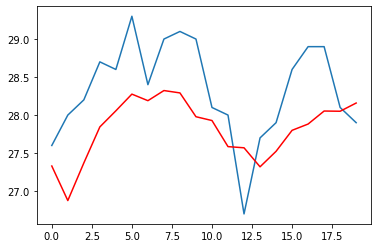

In [252]:
plt.plot(test.values)
plt.plot(predictions,color='red')

In [263]:
rmse = np.sqrt(((test.values - predictions) ** 2).mean())

In [268]:
print("RMSE:", round(rmse,1))

RMSE: 0.7


RMSE (root-mean-square error) is a measure of the differences between values predicted by a model and the values observed.
My ARIMA model has a RMSE score of 0.7 degreee celsius